# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

# Import

In [1]:
%matplotlib inline

from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.models.autoencoders import build_conv_autoencoder, build_dense_autoencoder
from debruiteur.models.gan import GAN
from debruiteur.noise.noise import *
from debruiteur.plots.plots import plot_model_loss
from debruiteur.preprocessing.preprocessor import *
from debruiteur.utils.utils import save_model, split_train_val_df

import os

# Configurations

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=10),
    UniformNoise(amplitude=100),
]

# Create Dataframe

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))
df_train, df_val = split_train_val_df(df_noised)

# Models training

## Data generator

In [4]:
train_gen = DataGenerator(df_train)
val_gen = DataGenerator(df_val)

## Convolutional autoencoder

In [5]:
ae_model = build_conv_autoencoder()
ae_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        2

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 56 steps, validate for 15 steps
Epoch 1/10
56/56 [==============================] - 183s 3s/step - loss: 0.0452 - val_loss: 0.0276
Epoch 2/10
56/56 [==============================] - 170s 3s/step - loss: 0.0204 - val_loss: 0.0184
Epoch 3/10
56/56 [==============================] - 162s 3s/step - loss: 0.0157 - val_loss: 0.0158
Epoch 4/10
56/56 [==============================] - 116s 2s/step - loss: 0.0138 - val_loss: 0.0153
Epoch 5/10
56/56 [==============================] - 112s 2s/step - loss: 0.0129 - val_loss: 0.0138
Epoch 6/10
56/56 [==============================] - 120s 2s/step - loss: 0.0122 - val_loss: 0.0134
Epoch 7/10
56/56 [==============================] - 113s 2s/step - loss: 0.0120 - val_loss: 0.0134
Epoch 8/10
56/56 [==============================] - 112s 2s/step - loss: 0.0115 - val_loss: 0.0125
Epoch 9/10
56/56 [======================

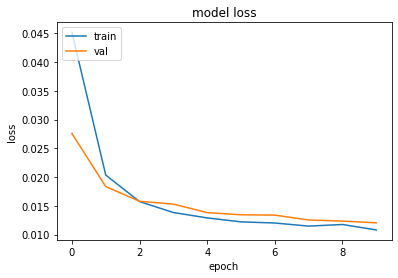

In [6]:
history = ae_model.fit_generator(train_gen, validation_data=val_gen, epochs=10)
plot_model_loss(history)

In [7]:
save_model(ae_model, os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")

del ae_model
del train_gen
del val_gen

## Dense autoencoder

In [ ]:
train_gen = DataGenerator(df_train, img_shape=(10000, ))
val_gen = DataGenerator(df_val, img_shape=(10000, ))

In [ ]:
ae_model = build_dense_autoencoder(loss="mse")
ae_model.summary()

In [ ]:
history = ae_model.fit_generator(train_gen, validation_data=val_gen, epochs=10)
plot_model_loss(history)

In [ ]:
save_model(ae_model, os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")

del ae_model
del train_gen
del val_gen

## GAN autoencoder

Was trained only on :
* gaussian noise
* uniform noise

As the model is quite heavy it was trained on google collaboratory. The code is however the same.

In [ ]:
train_gen = DataGenerator(df_train, img_shape=(100, 100, 1))
val_gen = DataGenerator(df_val, img_shape=(100, 100, 1))

In [ ]:
gan = GAN(img_shape=(100, 100, 1))

In [ ]:
gan.generator.summary()

In [ ]:
gan.discriminator.summary()

In [ ]:
gan.train(train_gen, val_gen, batch_size=20)

In [ ]:
save_model(gan.generator, os.path.join(working_dir, "saved_models"), "gan_generator.h5")

del gan
del train_gen
del val_gen